In [ ]:
#import the libraries 
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras.layers import LeakyReLU as LR
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load MNIST dataset
(input_train_1, target_train_1), (input_test_1, target_test_1) = mnist.load_data()

In [ ]:
print(input_train_1.shape)
print(input_test_1.shape)
print(target_train_1.shape)
print(target_test_1.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [ ]:
input_train=input_train_1[0:20000]
target_train=target_train_1[0:20000]
input_test=input_test_1[0:5000]
target_test=target_test_1[0:5000]

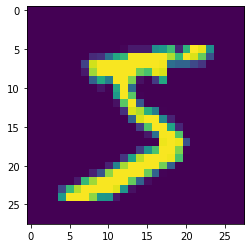

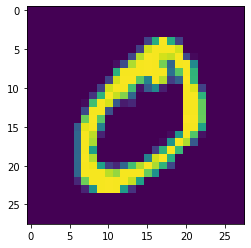

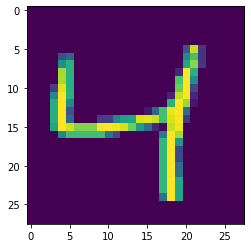

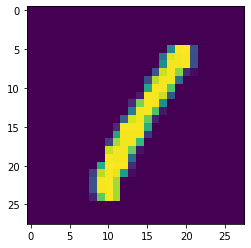

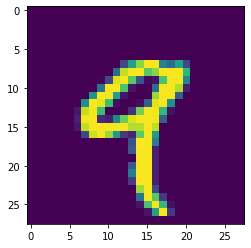

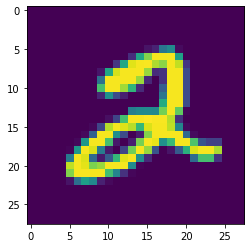

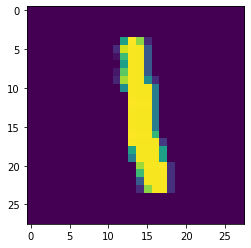

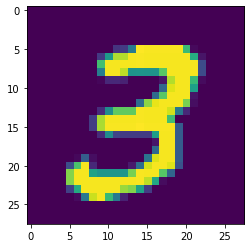

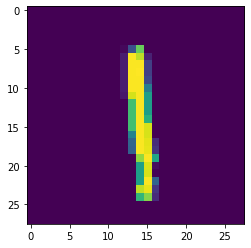

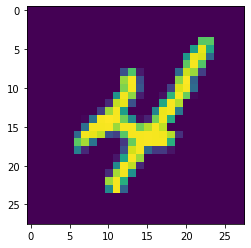

In [ ]:
for i in range(10):
  pr_image = input_train[i]
  pr_image = np.array(pr_image, dtype='float')
  pixels = pr_image.reshape((28, 28))
  plt.imshow(pixels)
  plt.show()

In [ ]:
print(input_train.shape)
print(input_test.shape)
print(target_train.shape)
print(target_test.shape)

(20000, 28, 28)
(5000, 28, 28)
(20000,)
(5000,)


In [ ]:
# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 50
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

In [ ]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

In [ ]:
# Encoder Definition
i       = Input(shape=input_shape, name='encoder_input')
cx      = LR()(i)
cx      = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = MaxPooling2D((1,1), padding ='same')(cx)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = MaxPooling2D((1,1), padding ='same')(cx)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)

x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)

mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

In [ ]:
# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

In [ ]:
# Define sampling with reparameterization trick
def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

In [ ]:
# Use reparameterization trick to ensure correct gradient
z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

In [ ]:
# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
leaky_re_lu_15 (LeakyReLU)      (None, 28, 28, 1)    0           encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 14, 14, 8)    80          leaky_re_lu_15[0][0]             
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 14, 14, 8)    0           conv2d_29[0][0]                  
____________________________________________________________________________________________

In [ ]:
# Decoder Definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = MaxPooling2D((1,1), padding ='same')(x)
cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx    = UpSampling2D((1,1))(cx)
cx    = BatchNormalization()(cx)
cx    = MaxPooling2D((1,1), padding ='same')(cx)
cx    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx    = UpSampling2D((1,1))(cx)
cx    = BatchNormalization()(cx)
x     = LR()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(x)

In [ ]:
# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 3136)              9408      
_________________________________________________________________
batch_normalization_46 (Batc (None, 3136)              12544     
_________________________________________________________________
reshape_6 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 14, 14, 16)        9232      
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 14, 14, 16)        0   

In [ ]:
# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 87768     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         32513     
Total params: 120,281
Trainable params: 113,681
Non-trainable params: 6,600
_________________________________________________________________


In [ ]:
tf.config.run_functions_eagerly(True)
# Compile VAE
vae.compile(optimizer='adam', loss='binary_crossentropy')

# Train autoencoder
vae.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
125/125 [==============================] - 10s 78ms/step - loss: 0.4807 - val_loss: 0.4063
Epoch 2/50
125/125 [==============================] - 10s 82ms/step - loss: 0.2698 - val_loss: 0.2909
Epoch 3/50
125/125 [==============================] - 10s 77ms/step - loss: 0.2369 - val_loss: 0.2737
Epoch 4/50
125/125 [==============================] - 10s 79ms/step - loss: 0.2243 - val_loss: 0.2756
Epoch 5/50
125/125 [==============================] - 10s 77ms/step - loss: 0.2190 - val_loss: 0.2759
Epoch 6/50
125/125 [==============================] - 10s 78ms/step - loss: 0.2151 - val_loss: 0.2776
Epoch 7/50
125/125 [==============================] - 10s 77ms/step - loss: 0.2124 - val_loss: 0.2778
Epoch 8/50
125/125 [==============================] - 10s 79ms/step - loss: 0.2106 - val_loss: 0.2779
Epoch 9/50
125/125 [==============================] - 10s 79ms/step - loss: 0.2074 - val_loss: 0.2755
Epoch 10/50
125/125 [==============================] - 10s 79ms/step - loss: 0.205

In [ ]:
# Results visualization
# Credits for original visualization code: https://keras.io/examples/variational_autoencoder_deconv/


def viz_latent_space(encoder, data):
  input_data, target_data = data
  mu, _, _ = encoder.predict(input_data)
  plt.figure(figsize=(8, 10))
  plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  plt.colorbar()
  plt.show()

In [ ]:
def viz_decoded(encoder, decoder, data):
  num_samples = 15
  figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
  grid_x = np.linspace(-4, 4, num_samples)
  grid_y = np.linspace(-4, 4, num_samples)[::-1]
  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded[0].reshape(img_width, img_height, num_channels)
          figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
  plt.figure(figsize=(10, 10))
  start_range = img_width // 2
  end_range = num_samples * img_width + start_range + 1
  pixel_range = np.arange(start_range, end_range, img_width)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
  # So reshape if necessary
  fig_shape = np.shape(figure)
  if fig_shape[2] == 1:
    figure = figure.reshape((fig_shape[0], fig_shape[1]))
  # Show image
  plt.imshow(figure)
  plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


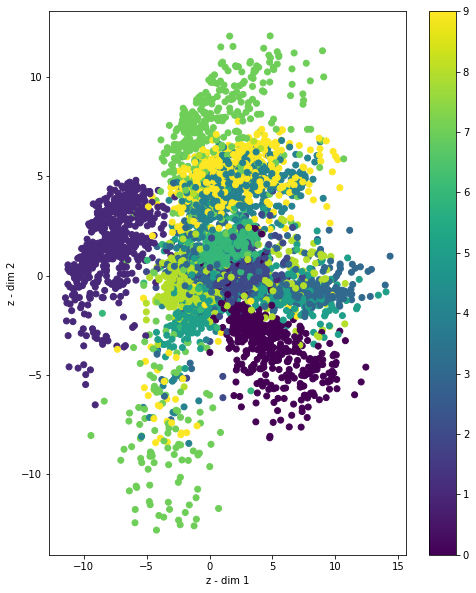

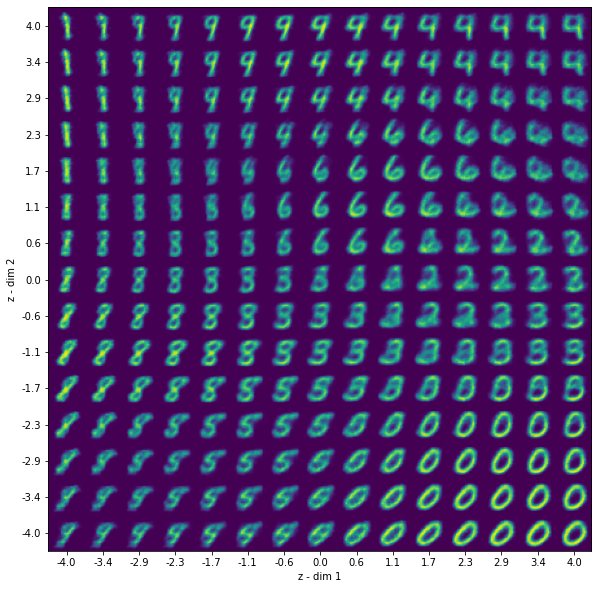

In [ ]:
# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)
viz_decoded(encoder, decoder, data)